## Bayes Semester Project Code
## Turkish Divorce Prediction
Anna Landi (aol4h) and Ryan Pindale (mwp8zy)

### Data Prep

In [ ]:
# import packages
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statistics
from scipy.stats import norm
az.style.use("arviz-darkgrid")

In [ ]:
# read in data set
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/
divorce = pd.read_excel("divorce.xlsx")
divorce = divorce - 2 # center the data around 0, which should make the model paramters more interpretable
divorce

Mounted at /content/drive
/content/drive/MyDrive


,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,Atr11,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr19,Atr20,Atr21,Atr22,Atr23,Atr24,Atr25,Atr26,Atr27,Atr28,Atr29,Atr30,Atr31,Atr32,Atr33,Atr34,Atr35,Atr36,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,0,0,2,-1,-2,-2,-2,-2,-2,-2,-1,-2,-1,-1,-2,-1,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,0,-1,0,-2,-1,0,-1,1,1,0,-1,-1,0,1,0,-1,1,1,1,0,1,0,-1,-1
1,2,2,2,2,2,-2,-2,2,2,2,2,1,2,-2,2,2,2,2,1,0,-1,-1,-2,0,0,-1,0,-2,-1,-1,-2,2,0,1,-2,0,1,2,0,2,0,0,1,2,0,0,0,1,2,2,2,2,0,0,-1
2,0,0,0,0,-1,1,0,-1,-1,0,1,2,0,1,1,1,1,1,1,0,-1,-2,-1,0,0,0,0,0,1,0,1,1,-1,-1,-1,-1,0,-1,1,1,1,1,0,1,0,1,0,1,-1,-1,-1,0,0,0,-1
3,1,0,1,0,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,2,-1,-1,-1,-1,0,-1,-1,-1,-1,1,0,1,0,0,-1,-1,1,1,2,2,0,0,1,0,1,0,0,1,1,1,1,0,0,0,-1
4,0,0,-1,-1,-1,-1,-2,-2,-2,-2,-2,-1,-2,-1,-1,-1,-1,-1,0,-1,-1,-2,-2,-2,-2,0,-1,0,-1,-1,-1,-1,-1,-1,-2,-2,-2,-2,0,-1,-2,0,1,-2,0,0,-1,0,1,0,0,0,-1,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,2,2,1,2,-2,-2,2,-2,-1,-2,-1,-2,-2,-2,-2,-1,-2,2,-1,-1,2,0,0,0,-2
166,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,2,-1,0,0,0,0,1,0,0,-2
167,-1,-1,-2,-2,-2,-2,-2,-2,-2,-1,-2,-1,-1,-2,-2,-1,-2,-2,-2,-1,-2,-2,-2,-2,-1,-1,-1,-2,-2,-1,-1,-1,-2,-1,-2,-2,-1,-1,-1,0,-1,1,1,-2,0,1,-2,0,-2,-1,-1,1,-2,-2,-2
168,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-1,-2,2,-1,0,-1,-1,-2,2,1,1,0,0,1,0,2,1,-1,-2


In [ ]:
# data set quick view
divorce.describe()

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,Atr11,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr19,Atr20,Atr21,Atr22,Atr23,Atr24,Atr25,Atr26,Atr27,Atr28,Atr29,Atr30,Atr31,Atr32,Atr33,Atr34,Atr35,Atr36,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,-0.223529,-0.347059,-0.235294,-0.517647,-0.458824,-1.252941,-1.505882,-0.547059,-0.541176,-0.423529,-0.311765,-0.347059,-0.164706,-0.429412,-0.429412,-0.523529,-0.347059,-0.482353,-0.358824,-0.541176,-0.611765,-0.752941,-0.588235,-0.488235,-0.370588,-0.511765,-0.600000,-0.694118,-0.505882,-0.505882,0.123529,0.058824,-0.194118,-0.100000,-0.329412,-0.394118,0.088235,-0.141176,0.088235,-0.129412,-0.005882,0.158824,0.705882,-0.058824,0.458824,0.552941,0.270588,0.741176,0.382353,0.429412,0.476471,0.517647,0.241176,0.011765,-1.505882
std,1.627257,1.468654,1.415444,1.504327,1.632169,0.904046,0.898698,1.546371,1.557976,1.421529,1.647082,1.468654,1.478421,1.502765,1.506697,1.504246,1.614512,1.565998,1.641027,1.554173,1.452149,1.446529,1.612041,1.504385,1.530079,1.500447,1.457078,1.467788,1.592315,1.504420,1.646955,1.623445,1.785202,1.630515,1.842228,1.798412,1.716051,1.734802,1.719496,1.796039,1.721761,1.574034,1.348447,1.684267,1.499925,1.371786,1.586841,1.137348,1.511587,1.405090,1.260238,1.476537,1.505634,1.667611,0.501442
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,-2.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-2.000000,-2.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,-2.000000,-2.000000,-1.000000,-1.000000,0.000000,-1.000000,-0.500000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.500000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.500000,-2.000000,0.000000,-1.000000,0.000000,-0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-2.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2

In [ ]:
# drop "Class" column from data frame
divorce_new = divorce.drop(columns = ["Class"])
divorce_new

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,Atr11,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr19,Atr20,Atr21,Atr22,Atr23,Atr24,Atr25,Atr26,Atr27,Atr28,Atr29,Atr30,Atr31,Atr32,Atr33,Atr34,Atr35,Atr36,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54
0,0,0,2,-1,-2,-2,-2,-2,-2,-2,-1,-2,-1,-1,-2,-1,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,0,-1,0,-2,-1,0,-1,1,1,0,-1,-1,0,1,0,-1,1,1,1,0,1,0,-1
1,2,2,2,2,2,-2,-2,2,2,2,2,1,2,-2,2,2,2,2,1,0,-1,-1,-2,0,0,-1,0,-2,-1,-1,-2,2,0,1,-2,0,1,2,0,2,0,0,1,2,0,0,0,1,2,2,2,2,0,0
2,0,0,0,0,-1,1,0,-1,-1,0,1,2,0,1,1,1,1,1,1,0,-1,-2,-1,0,0,0,0,0,1,0,1,1,-1,-1,-1,-1,0,-1,1,1,1,1,0,1,0,1,0,1,-1,-1,-1,0,0,0
3,1,0,1,0,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,2,-1,-1,-1,-1,0,-1,-1,-1,-1,1,0,1,0,0,-1,-1,1,1,2,2,0,0,1,0,1,0,0,1,1,1,1,0,0,0
4,0,0,-1,-1,-1,-1,-2,-2,-2,-2,-2,-1,-2,-1,-1,-1,-1,-1,0,-1,-1,-2,-2,-2,-2,0,-1,0,-1,-1,-1,-1,-1,-1,-2,-2,-2,-2,0,-1,-2,0,1,-2,0,0,-1,0,1,0,0,0,-1,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,2,2,1,2,-2,-2,2,-2,-1,-2,-1,-2,-2,-2,-2,-1,-2,2,-1,-1,2,0,0,0
166,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,2,-1,0,0,0,0,1,0,0
167,-1,-1,-2,-2,-2,-2,-2,-2,-2,-1,-2,-1,-1,-2,-2,-1,-2,-2,-2,-1,-2,-2,-2,-2,-1,-1,-1,-2,-2,-1,-1,-1,-2,-1,-2,-2,-1,-1,-1,0,-1,1,1,-2,0,1,-2,0,-2,-1,-1,1,-2,-2
168,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-1,-2,2,-1,0,-1,-1,-2,2,1,1,0,0,1,0,2,1,-1


In [ ]:
# extract "Class" column from data frame
couple_outcome = divorce["Class"]
couple_outcome = couple_outcome + 2 # this should bring it back to a 0-1 output
couple_outcome

0      1
1      1
2      1
3      1
4      1
      ..
165    0
166    0
167    0
168    0
169    0
Name: Class, Length: 170, dtype: int64

### Full Model (54 Predictors)

In [ ]:
# generate full model
k = 54 # number of predictors
with pm.Model() as logistic_full_model:
    β0 = pm.Normal("β0", mu = 0, sd = 3)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 3*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(divorce_new, β)
    θ = pm.Deterministic("θ",  pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = couple_outcome)
    trace_full_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.


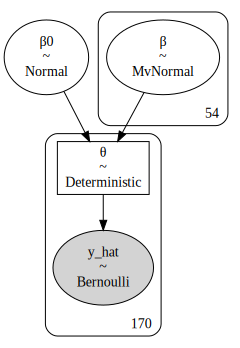

In [ ]:
# produce graphical representation
pm.model_to_graphviz(logistic_full_model)

In [ ]:
# produce summary table
with logistic_full_model:
    log_data = az.from_pymc3(trace_full_model)
az.summary(log_data, var_names = ["β0", "β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,3.308,2.564,-1.533,8.013,0.069,0.055,1404.0,1322.0,1.00
β[0],0.793,1.429,-1.798,3.436,0.036,0.026,1540.0,1922.0,1.00
β[1],0.665,1.500,-2.124,3.472,0.042,0.030,1285.0,1859.0,1.01
β[2],1.009,1.366,-1.581,3.631,0.035,0.026,1502.0,1562.0,1.00
β[3],-0.263,1.438,-3.021,2.297,0.036,0.036,1611.0,1542.0,1.00
β[4],-0.300,1.515,-3.163,2.564,0.037,0.026,1654.0,1841.0,1.00
β[5],0.992,1.507,-1.784,3.798,0.041,0.029,1396.0,1713.0,1.00
β[6],-0.935,1.492,-3.740,1.902,0.044,0.031,1155.0,1517.0,1.00
β[7],0.054,1.634,-3.110,2.960,0.045,0.037,1403.0,1465.0,1.00
β[8],0.143,1.585,-2.892,3.007,0.044,0.031,1317.0,1686.0,1.00


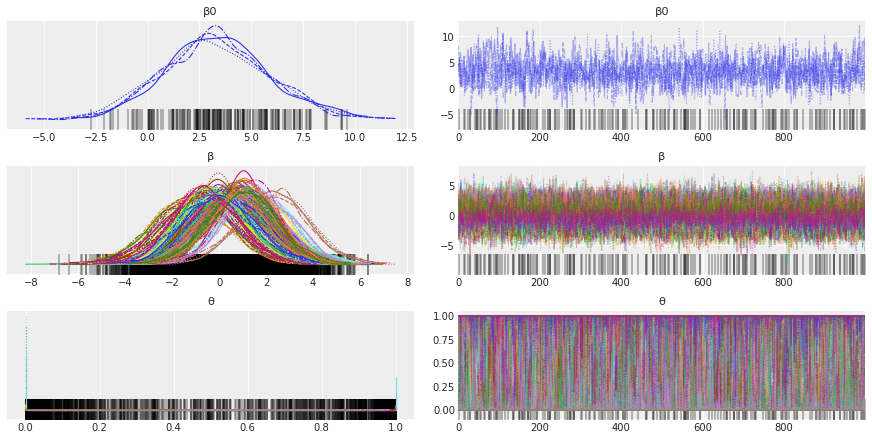

In [ ]:
# produce trace plots
with pm.Model() as logistic_full_model:
    az.plot_trace(trace_full_model)

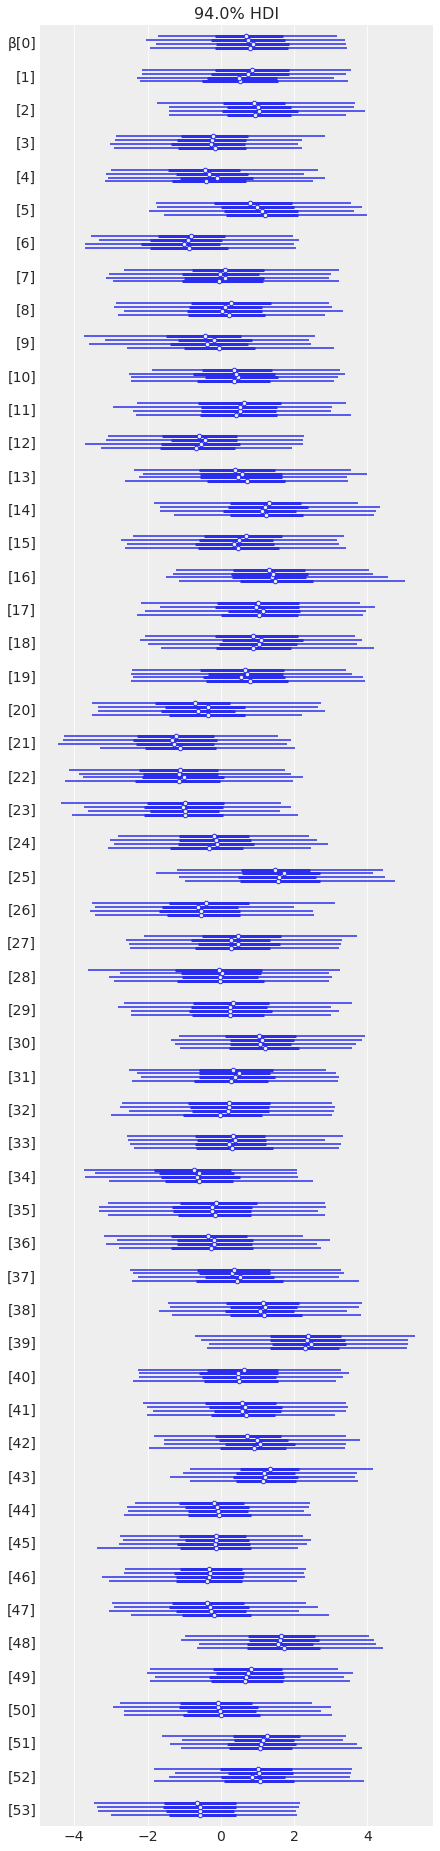

In [ ]:
# produce forest plots
with logistic_full_model:
    az.plot_forest(trace_full_model, var_names = ["β"])

### Reduced Models (with fewer predictors)
Method: taking a look at the correlations, we will extract some of the highly correlated predictors used in subsequnet reduced models.

In [ ]:
correlations = divorce_new.corr()
list_of_correlated_highly_predictors = []
for i in range(0, 54):
  for j in range(0, 54):
    if correlations.iloc[i, j] > 0.9:
      if i < j:
        list_of_correlated_highly_predictors.append(("Atr" + str(i + 1), "Atr" + str(j + 1)))

### Reduced Model 1 (46 Predictors)

In [ ]:
# generate first reduced model
divorce_reduced1 = divorce_new.drop(columns = ["Atr5", "Atr8", "Atr9", "Atr11", "Atr14", "Atr18", "Atr33", "Atr34"])
k = len(divorce_reduced1.columns) # number of predictors
with pm.Model() as logistic_reduced1_model:
    β0 = pm.Normal("β0", mu = 0, sd = 3)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 3*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(divorce_reduced1, β)
    θ = pm.Deterministic("θ",  pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = couple_outcome)
    trace_reduced1_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.


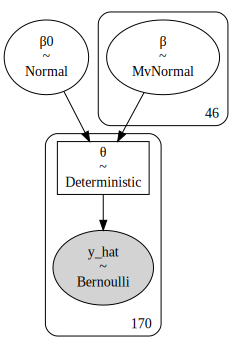

In [ ]:
# produce graphical representation
pm.model_to_graphviz(logistic_reduced1_model)

In [ ]:
# produce summary table
with logistic_reduced1_model:
    log_data = az.from_pymc3(trace_reduced1_model)
az.summary(log_data, var_names = ["β0", "β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,3.228,2.698,-1.852,8.436,0.076,0.062,1302.0,975.0,1.00
β[0],0.798,1.384,-1.722,3.510,0.036,0.026,1455.0,1499.0,1.00
β[1],0.787,1.442,-1.840,3.589,0.038,0.029,1414.0,1385.0,1.00
β[2],0.931,1.384,-1.586,3.513,0.039,0.028,1264.0,1301.0,1.00
β[3],-0.287,1.425,-3.027,2.363,0.041,0.029,1199.0,1610.0,1.00
β[4],1.184,1.414,-1.389,3.848,0.038,0.027,1375.0,1691.0,1.00
β[5],-0.916,1.571,-3.870,2.007,0.041,0.030,1528.0,1449.0,1.00
β[6],-0.042,1.485,-2.705,2.910,0.035,0.026,1847.0,2023.0,1.00
β[7],0.491,1.559,-2.407,3.453,0.043,0.031,1296.0,1720.0,1.00
β[8],-0.481,1.487,-3.072,2.450,0.036,0.027,1665.0,1856.0,1.00


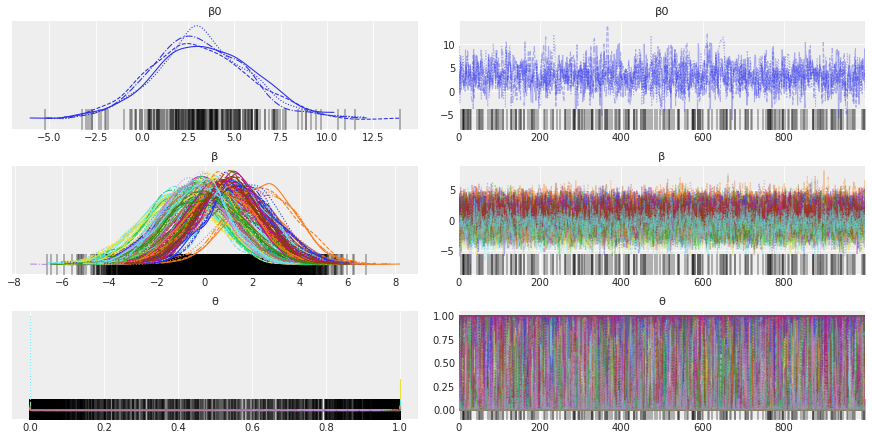

In [ ]:
# produce trace plots
with pm.Model() as logistic_reduced1_model:
    az.plot_trace(trace_reduced1_model)

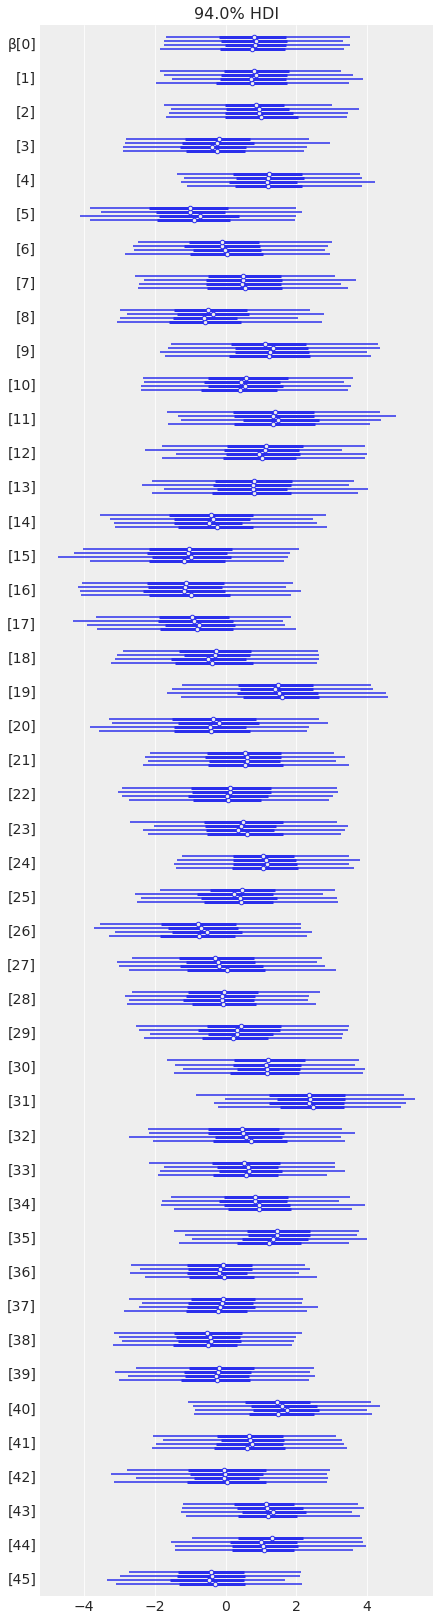

In [ ]:
# produce forest plots
with logistic_reduced1_model:
    az.plot_forest(trace_reduced1_model, var_names = ["β"])

### Reduced Model 2 (32 Predictors)

In [ ]:
# generate second reduced model
divorce_reduced2 = divorce_new.drop(columns = ["Atr19", "Atr11", "Atr13", "Atr17", "Atr29", "Atr8", "Atr15",
                                               "Atr18", "Atr20", "Atr21", "Atr27", "Atr16", "Atr30", "Atr28", 
                                               "Atr25", "Atr26", "Atr34", "Atr35", "Atr36", "Atr54", "Atr40", "Atr41"])
k = len(divorce_reduced2.columns) # number of predictors
with pm.Model() as logistic_reduced2_model:
    β0 = pm.Normal("β0", mu = 0, sd = 3)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 3*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(divorce_reduced2, β)
    θ = pm.Deterministic("θ",  pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = couple_outcome)
    trace_reduced2_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


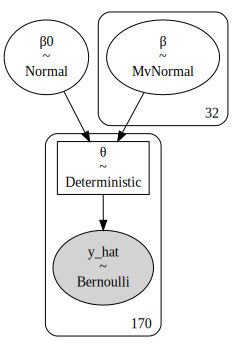

In [ ]:
# produce graphical representation
pm.model_to_graphviz(logistic_reduced2_model)

In [ ]:
# produce summary table
with logistic_reduced2_model:
    log_data = az.from_pymc3(trace_reduced2_model)
az.summary(log_data, var_names = ["β0", "β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,3.796,2.347,-0.452,8.359,0.053,0.038,1990.0,2079.0,1.0
β[0],1.603,1.334,-0.860,4.148,0.029,0.022,2083.0,1995.0,1.0
β[1],1.191,1.356,-1.316,3.725,0.030,0.023,2049.0,1828.0,1.0
β[2],1.048,1.229,-1.316,3.280,0.027,0.022,2031.0,1613.0,1.0
β[3],-0.275,1.321,-2.828,2.134,0.031,0.023,1811.0,2004.0,1.0
β[4],-0.175,1.417,-2.990,2.411,0.031,0.027,2088.0,1723.0,1.0
β[5],1.928,1.260,-0.299,4.400,0.029,0.021,1906.0,2077.0,1.0
β[6],-0.849,1.397,-3.485,1.686,0.031,0.024,1974.0,2242.0,1.0
β[7],0.549,1.524,-2.267,3.351,0.034,0.027,1991.0,1952.0,1.0
β[8],0.031,1.415,-2.667,2.659,0.032,0.027,1936.0,1961.0,1.0


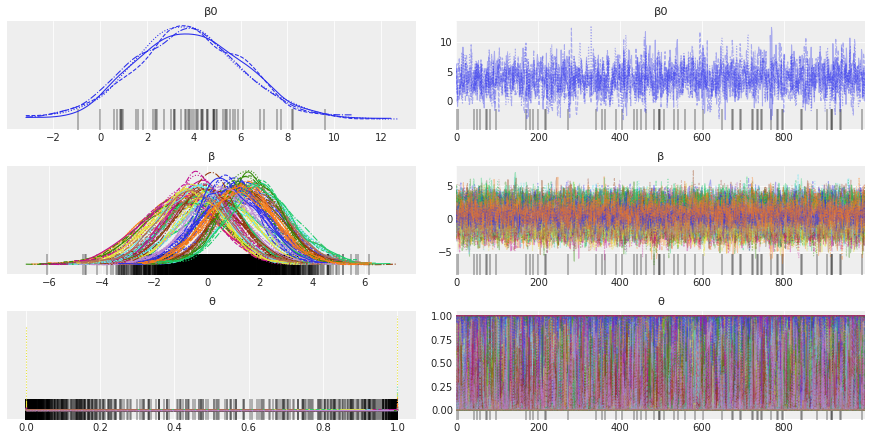

In [ ]:
# produce trace plots
with pm.Model() as logistic_reduced2_model:
    az.plot_trace(trace_reduced2_model)

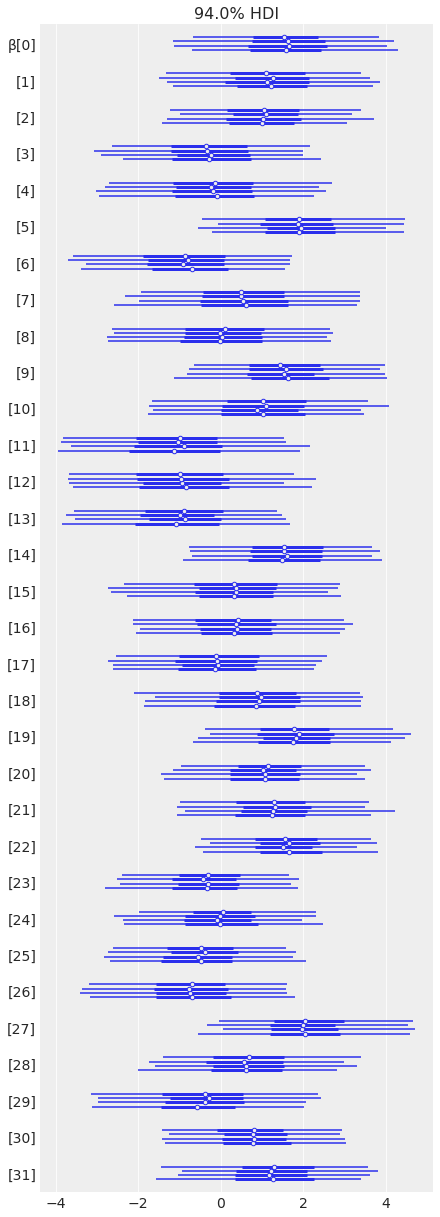

In [ ]:
# produce forest plots
with logistic_reduced2_model:
    az.plot_forest(trace_reduced2_model, var_names = ["β"])

### Reduced Model 3 (6 Predictors) - Recommended by Researchers
Note: use both sampling method and variational inference method.

In [ ]:
# model recommended by researchers (6 predictors)
divorce_reduced3 = divorce_new[["Atr2", "Atr6", "Atr11", "Atr18", "Atr26", "Atr40"]]
k = len(divorce_reduced3.columns) # number of predictors
with pm.Model() as logistic_reduced3_model:
    β0 = pm.Normal("β0", mu = 0, sd = 3)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 3*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(divorce_reduced3, β)
    θ = pm.Deterministic("θ",  pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = couple_outcome)
    trace_reduced3_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

NameError: ignored

In [ ]:
# produce graphical representation
pm.model_to_graphviz(logistic_reduced3_model)

In [ ]:
# produce summary table
with logistic_reduced3_model:
    log_data = az.from_pymc3(trace_reduced3_model)
az.summary(log_data, var_names = ["β0", "β"])

In [ ]:
holder = az.summary(log_data, var_names = ["β0", "β"])
holder.T

In [ ]:
thetas = az.summary(log_data, var_names = ["θ"])
count = 0
for i in range(len(thetas)):
  if np.abs(thetas["mean"][i] - couple_outcome[i]) > 0.5:
    count += 1
count

In [ ]:
# produce trace plots
with pm.Model() as logistic_reduced3_model:
    az.plot_trace(trace_reduced3_model)

In [ ]:
# produce forest plots
with logistic_reduced3_model:
    az.plot_forest(trace_reduced3_model, var_names = ["β"])

In [ ]:
# develop a variational inference estimate using ADVI optimization for the posterior distributions of the parameters in model recommended by researchers
divorce_reduced3 = divorce_new[["Atr2", "Atr6", "Atr11", "Atr18", "Atr26", "Atr40"]]
k = len(divorce_reduced3.columns) # number of predictors
with pm.Model() as logistic_reduced3_advi_model:
    β0 = pm.Normal("β0", mu = 0, sd = 3)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 3*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(divorce_reduced3, β)
    θ = pm.Deterministic("θ",  pm.invlogit(μ))
    y_hat_advi = pm.Bernoulli("y_hat_advi", p = θ, observed = couple_outcome)
    advi_fit = pm.fit(50000, method = "advi")

In [ ]:
# produce forest plots
samples = 50000
advi_trace = advi_fit.sample(samples)

with logistic_reduced3_advi_model:
    az.plot_forest(advi_trace, var_names = ["β"])

In [ ]:
# ELBO plot from the optimization
advi_elbo = pd.DataFrame(
    {"ELBO": -advi_fit.hist,
     "n": np.arange(advi_fit.hist.shape[0])})
plt.figure(dpi = 100)
ax = sns.lineplot(y = "ELBO", x = "n", data = advi_elbo)
ax.set_title("ELBO vs. Time")
plt.show()

In [ ]:
divorce_reduced3 = divorce_new[["Atr2", "Atr6", "Atr11", "Atr18", "Atr26", "Atr40"]]
pred = list(divorce_reduced3.columns)
pred

burnin = 100
sample_intercept = trace_reduced3_model["β0"][burnin:]
sample_beta = trace_reduced3_model["β"][burnin:]
advi_intercept = advi_trace["β0"]
advi_beta = advi_trace["β"]

# plot posteriors
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 10), dpi = 150, constrained_layout = False)
for ax, sampling_estimate, advi_estimate, title, xlabel in zip(axes.ravel(),
                                                        [sample_intercept] + [sample_beta[:, i] for i in range(6)],
                                                        [advi_intercept] + [advi_beta[:, i] for i in range(6)],
                                                        ["Intercept"] + pred,
                                                        ["Intercept"] + pred):
  pm.plot_posterior(sampling_estimate, ax = ax, color = "blue", point_estimate = None, alpha = 0.5)
  pm.plot_posterior(advi_estimate, ax = ax, color = "red", point_estimate = None, hdi_prob = "hide", alpha = 0.5)
  ax.set_title(title, fontsize = 12)

plt.suptitle("Regression Parameters - Sampling in Blue and Variational Inference in Red")
plt.tight_layout()
plt.subplots_adjust(top = 0.8)
plt.show()

examine how the parameters change with different priors and models

In [ ]:
six_pred_index = [1, 5, 10, 17, 25, 39]
six_pred_index

def test_model_params(columns = divorce_new.columns, int_cov_factor = 1, p_cov_factor = 1):
  k = len(columns)
  with pm.Model() as logistic_model:
    β0 = pm.Normal("β0", mu = 0, sd = int_cov_factor)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = p_cov_factor*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(divorce_new[columns], β)
    θ = pm.Deterministic("θ",  pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = couple_outcome)
    trace_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

  with logistic_model:
    log_data = az.from_pymc3(trace_model)
  if k > 50:
    holder = az.summary(log_data, var_names = ["β", "β0"]).iloc[six_pred_index]
  else:
    holder = az.summary(log_data, var_names = ["β"])
  return(holder)

In [ ]:
covs = [0.5, 1, 3, 5, 10]

fig, axs = plt.subplots(2, 3, figsize = (15, 15))
for j in covs:
  this_holder = test_model_params(int_cov_factor = j, p_cov_factor = j)
  x = np.linspace(-5, 7, 100)
  for i in range(len(this_holder)):
    if i < 3:
      axs[0, i].plot(x, norm.pdf(x, this_holder["mean"][i], this_holder["sd"][i]), label = "cov = " + str(j))
      axs[0, i].set_title("β" + str(six_pred_index[i]))
      axs[0, i].legend()
    else:
      axs[1, i-3].plot(x, norm.pdf(x, this_holder["mean"][i], this_holder["sd"][i]), label = "cov = " + str(j))
      axs[1, i-3].set_title("β" + str(six_pred_index[i]))
      axs[1, i-3].legend()

In [ ]:
covs = [0.5, 1, 3, 5, 10]

fig, axs = plt.subplots(2, 3, figsize = (15, 15))
for j in covs:
  this_holder = test_model_params(columns=["Atr2", "Atr6", "Atr11", "Atr18", "Atr26", "Atr40"], int_cov_factor = j, p_cov_factor = j)
  x = np.linspace(-5, 7, 100)
  for i in range(len(this_holder)):
    if i < 3:
      axs[0, i].plot(x, norm.pdf(x, this_holder["mean"][i], this_holder["sd"][i]), label = "cov = " + str(j))
      axs[0, i].set_title("β" + str(six_pred_index[i]))
      axs[0, i].legend()
    else:
      axs[1, i-3].plot(x, norm.pdf(x, this_holder["mean"][i], this_holder["sd"][i]), label = "cov = " + str(j))
      axs[1, i-3].set_title("β" + str(six_pred_index[i]))
      axs[1, i-3].legend()

In [ ]:
# model comparisons with WAIC and weights
# use WAIC to recommend which of these models to use
cmp_df = az.compare({"full model": trace_full_model, "small model": trace_reduced1_model, "smaller model": trace_reduced2_model, "recommended model": trace_reduced3_model},
                    ic = "WAIC",
                    method = "BB-pseudo-BMA")
cmp_df

In [ ]:
# produce plot to compare different models
az.plot_compare(cmp_df, figsize = (10, 8))

### Variational Autoencoder
In this seciton, we build a Variational Autoencoder (VAE). The decoder performs terribly since we only have 170 total observations. We include logistic regression on the 4 bottleneck vaiables anyway, but we are not using the results in our report. Assumption is that if we had a lot more data, we could plug it in and the VAE should work. We used the following website as a guide for the code: https://blog.keras.io/building-autoencoders-in-keras.html.

In [ ]:
import keras
from keras import layers

encoding_dim = 4

input = keras.Input(shape = (len(divorce_new.columns),))

encoded = layers.Dense(encoding_dim, activation = "selu")(input)

decoded = layers.Dense(len(divorce_new.columns), activation = "selu")(encoded)

autoencoder = keras.Model(input, decoded)

encoder = keras.Model(input, encoded)

encoded_input = keras.Input(shape = (encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = "adam", loss = "KLDivergence")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(divorce_new, couple_outcome, test_size = 0.1, random_state = 42)

autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = 2,
                shuffle = True,
                validation_data = (X_test, X_test))

latent_bottleneck_vars = encoder.predict(divorce_new)

pd.DataFrame(decoder.predict(latent_bottleneck_vars))

Epoch 1/50
77/77 [==============================] - 1s 5ms/step - loss: 193.0918 - val_loss: 184.8614
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 170.5999 - val_loss: 153.6322
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 141.9814 - val_loss: 129.0074
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 126.0608 - val_loss: 117.4880
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 112.0631 - val_loss: 94.2407
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 99.6502 - val_loss: 85.0787
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 94.3636 - val_loss: 83.2821
Epoch 8/50
77/77 [==============================] - 0s 2ms/step - loss: 92.2460 - val_loss: 82.1393
Epoch 9/50
77/77 [==============================] - 0s 2ms/step - loss: 90.8912 - val_loss: 81.1958
Epoch 10/50
77/77 [==============================] - 0s 2ms/step - loss: 88.9391 - val_loss

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,-0.528149,1.044193,-0.182557,0.767416,2.018214,-0.787029,1.434081,-0.764464,0.707750,0.559421,1.036585,-0.441378,0.133034,-0.648773,0.184149,0.621338,1.502313,1.048434,0.389040,1.097658,1.410614,-0.264047,0.606634,-0.163393,2.197291,0.912873,0.146605,-0.532824,0.109605,0.599128,1.492714,2.072909,0.365141,0.518744,0.181410,0.677316,0.640526,-0.265621,1.289427,-0.439530,-0.077197,1.153785,1.289399,1.387291,1.010694,2.593395,1.874165,-1.236834,0.473033,2.155777,-0.429983,2.773078,2.246220,-0.574972
1,0.646527,2.371761,0.218541,-1.216515,1.839457,0.753499,2.078751,2.661366,2.851178,2.384387,1.062641,2.110005,1.046507,2.301422,1.498143,1.376203,1.451591,2.538650,2.702014,0.365594,1.565413,1.711627,1.308825,2.120523,0.325810,0.605512,1.425598,0.938114,1.570973,0.710176,0.952905,2.795110,1.058211,2.789224,2.134581,2.573055,1.470247,1.614243,2.771791,-0.436144,1.853265,1.686167,1.805597,2.910882,-1.252522,4.208811,1.149660,0.876030,2.519190,3.279807,-1.044971,2.291310,0.704005,-1.471838
2,0.650495,1.011350,0.491411,-0.903567,0.274722,0.626821,0.463608,1.152428,0.744628,0.823812,0.202241,0.828758,0.268502,1.106357,0.751152,0.412922,0.440098,0.773995,1.104859,0.011363,0.409451,0.920145,0.313018,1.254367,-0.339339,0.445342,0.826896,1.420491,0.791406,0.530724,0.262287,0.441183,0.238555,0.887651,0.813346,0.748445,0.509755,0.743177,0.577685,0.690144,1.199975,0.265644,0.811096,0.717561,-0.854010,0.892350,0.136383,0.826278,0.749315,0.796592,0.419011,0.416096,-0.143214,-0.595988
3,1.408986,3.057517,1.195143,-1.357099,2.468382,-0.804221,2.432791,2.658066,2.431077,2.584979,1.530882,2.121175,1.004592,2.808447,1.854420,1.714253,2.148065,2.278796,3.174396,1.173585,2.132021,2.703801,1.692797,2.156810,1.452868,1.460363,2.333351,2.257656,2.053130,1.751566,1.619267,2.838026,1.062050,2.644250,2.082893,2.432621,1.148032,1.794922,2.348264,0.937361,2.610463,1.822894,1.874779,2.481696,-1.439267,3.442975,1.294351,1.224766,2.112104,3.009077,-0.877492,1.687336,1.330512,-1.568442
4,-1.156978,-0.330401,-1.102257,1.262402,0.285864,0.371182,-0.691379,-1.629820,-1.093230,-1.438853,-0.057777,-1.615655,-1.537275,-1.540150,-1.241212,-1.384233,0.170545,-0.602914,-1.316232,-0.510553,0.256945,-1.497228,-1.008280,-0.821792,0.913440,-0.357433,-1.243400,-0.754336,-1.367816,-0.311025,0.430262,-0.794972,-1.417184,-1.376798,-1.149446,-1.159801,0.134713,-1.555567,-0.592011,-0.335863,-0.911284,-0.752031,1.242827,0.017877,2.550186,0.785050,0.491188,-1.535893,-1.144683,0.582079,1.804035,0.947101,0.763161,1.560414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-1.408219,0.337907,-1.318735,2.032921,1.630902,-0.985633,-0.180701,-1.738006,-1.329562,-1.625176,0.641223,-1.733687,-1.709579,-1.686952,-1.509392,-1.584764,1.100069,-0.740602,-1.476786,0.123283,1.274922,-1.632148,-1.033617,-1.286851,2.868094,0.020016,-1.397231,-1.062232,-1.590414,0.295609,1.447686,-0.344495,-1.644334,-1.595026,-1.432871,-1.377589,0.136632,-1.715022,-0.488447,-0.399821,-1.076389,-0.545133,2.279326,0.379238,4.088682,1.890190,1.270651,-1.716591,-1.445981,1.572928,2.423389,1.609432,2.164217,1.828830
166,-1.459515,-0.793587,-1.415752,1.942136,0.583556,0.831251,-0.259741,-1.642887,-0.643357,-1.357296,0.022665,-1.590018,-1.359949,-1.634157,-1.304074,-1.239481,0.161594,0.044151,-1.430988,-0.432785,0.255787,-1.629200,-0.950778,-1.138130,1.030257,-0.642896,-1.476565,-1.529841,-1.439849,-0.975990,0.469685,0.316942,-1.165585,-1.216947,-1.129255,-0.909017,0.448432,-1.537154,0.332937,-1.317973,-1.408946,-0.166423,1.168980,0.657338,3.111650,1.984250,1.190965,-1.641807,-0.801099,1.317738,0.938156,2.481873,1.308093,1.553017
167,-1.244583,-0.991326,-1.313739,1.011041,-0.973777,1.833572,-1.136013,-1.48

In [ ]:
k = 4
with pm.Model() as logistic_latent_model:
    β0 = pm.Normal("β0", mu = 0, sd = 10)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 10*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(latent_bottleneck_vars, β)
    θ = pm.Deterministic("θ", pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = couple_outcome)
    trace_full_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

with logistic_latent_model:
  log_data = az.from_pymc3(trace_full_model)
az.summary(log_data, var_names = ["β0", "β", "θ"])[-10:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ[160],0.085,0.121,0.00,0.323,0.003,0.002,1393.0,1831.0,1.0
θ[161],0.072,0.076,0.00,0.219,0.002,0.001,1830.0,2533.0,1.0
θ[162],0.002,0.004,0.00,0.008,0.000,0.000,1053.0,1726.0,1.0
θ[163],0.055,0.059,0.00,0.166,0.001,0.001,1404.0,1843.0,1.0
θ[164],0.003,0.005,0.00,0.012,0.000,0.000,1117.0,2231.0,1.0
θ[165],0.001,0.004,0.00,0.003,0.000,0.000,1240.0,1532.0,1.0
θ[166],0.004,0.006,0.00,0.013,0.000,0.000,1164.0,1850.0,1.0
θ[167],0.523,0.284,0.08,0.989,0.007,0.005,1398.0,1418.0,1.0
θ[168],0.003,0.007,0.00,0.012,0.000,0.000,1273.0,1660.0,1.0


In [ ]:
with pm.Model() as logistic_latent_model:
    az.plot_trace(trace_full_model)

Below we did something that is not entirely appropriate for analysis. We did some heavy synthetic data creation (in a way that definitely amplified the bias in our data and will lead to overfitting in any model). But, we just wanted to see if we could get a VAE to work with more data, even if we could never use the bottleneck variables in reasonable analysis.

In [ ]:
test = pd.DataFrame()
test["test"] = list(divorce.query("Class=='-1'")["Atr1"].sample(n = 10000, replace = True))
test

,test
0,1
1,2
2,1
3,2
4,2
...,...
9995,1
9996,1
9997,1
9998,1


In [ ]:
divorced_synth = pd.DataFrame()
married_synth = pd.DataFrame()
for col in divorce_new.columns:
  divorced_synth[str(col)] = list(divorce.query("Class=='-1'")[str(col)].sample(n = 10000, replace = True))
  married_synth[str(col)] = list(divorce.query("Class=='-2'")[str(col)].sample(n = 10000, replace = True))
divorced_synth["Class"] = np.ones(10000)
married_synth["Class"] = np.zeros(10000)

In [ ]:
synth_full_data = pd.merge(married_synth, divorced_synth, how = "outer").sample(frac = 1)
synth_data = synth_full_data.drop("Class", axis = 1)
synth_class_data = synth_full_data["Class"]

In [ ]:
import keras
from keras import layers

encoding_dim = 4

input = keras.Input(shape = (len(synth_data.columns),))

encoded = layers.Dense(encoding_dim, activation = "selu")(input)

decoded = layers.Dense(len(synth_data.columns), activation = "selu")(encoded)

autoencoder = keras.Model(input, decoded)

encoder = keras.Model(input, encoded)

encoded_input = keras.Input(shape = (encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = "adam", loss = "KLDivergence")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(synth_data, synth_class_data, test_size = 0.1, random_state = 42)

autoencoder.fit(X_train, X_train,
                epochs = 10,
                batch_size = 2,
                shuffle = True,
                validation_data = (X_test, X_test))

latent_bottleneck_vars = encoder.predict(synth_data)

pd.DataFrame(decoder.predict(latent_bottleneck_vars))

Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 61.4282 - val_loss: 51.1604
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 51.1167 - val_loss: 51.1589
Epoch 3/10
9000/9000 [==============================] - 11s 1ms/step - loss: 51.1160 - val_loss: 51.1589
Epoch 4/10
9000/9000 [==============================] - 12s 1ms/step - loss: 51.1161 - val_loss: 51.1589
Epoch 5/10
9000/9000 [==============================] - 11s 1ms/step - loss: 51.1159 - val_loss: 51.1589
Epoch 6/10
9000/9000 [==============================] - 11s 1ms/step - loss: 51.1159 - val_loss: 51.1589
Epoch 7/10
9000/9000 [==============================] - 12s 1ms/step - loss: 51.1161 - val_loss: 51.1589
Epoch 8/10
9000/9000 [==============================] - 11s 1ms/step - loss: 51.1159 - val_loss: 51.1589
Epoch 9/10
9000/9000 [==============================] - 11s 1ms/step - loss: 51.1160 - val_loss: 51.1589
Epoch 10/10
9000/9000 [==============================] 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,-1.757938,-1.576202,-1.701692,-1.757919,-1.746905,2.708819,-1.755280,-1.757855,-1.756167,-1.754094,-1.752921,-1.614874,-1.755261,-1.295625,-1.231186,-1.534807,-1.685408,-1.745677,-1.756666,-1.643441,-1.661031,-1.747069,-1.632891,-1.750359,6.023149,-1.398002,-1.680074,-1.755143,6.107903,-1.756010,3.217866,-1.719584,-1.749477,-1.757220,-1.754630,-1.747604,2.683746,-1.757385,-1.748891,-1.756328,-1.757832,3.636221,-1.755677,2.902023,4.814382,-1.757583,-1.742259,-1.746689,-1.723134,-1.757992,2.918919,-1.741358,2.928895,-1.609186
1,-1.758035,-1.603204,-1.713229,-1.758026,-1.750916,3.014266,-1.756600,-1.757998,-1.757139,-1.755707,-1.754986,-1.635345,-1.756499,-1.334098,-1.251096,-1.556843,-1.699911,-1.750576,-1.757337,-1.664033,-1.680844,-1.751516,-1.658380,-1.753585,6.592995,-1.423899,-1.696702,-1.756436,6.654319,-1.756965,3.614482,-1.729514,-1.752963,-1.757676,-1.756190,-1.751494,2.833333,-1.757781,-1.752758,-1.757174,-1.757986,3.890031,-1.756780,3.256221,5.176816,-1.757861,-1.747874,-1.750627,-1.732870,-1.758059,3.264736,-1.746652,3.274369,-1.637998
2,2.662237,2.568850,4.126691,1.790348,3.295663,3.788098,3.907347,2.053266,1.731954,3.529509,2.433339,4.468456,3.167274,2.985832,5.631185,3.233548,3.286669,2.373584,3.780910,3.875997,4.573530,2.351511,3.039760,1.829538,-1.343331,3.595522,3.365801,2.110531,-1.412717,4.207814,3.104120,5.375556,3.612824,2.686942,4.599171,1.641349,-1.730996,2.113702,2.155080,1.734584,1.766589,-1.593545,2.623935,3.998283,-1.710755,1.755255,3.398047,3.396052,3.527008,1.398028,4.180816,3.253600,3.856967,3.846956
3,2.664199,2.561628,3.956100,1.772614,3.112215,3.721383,3.758140,2.059153,1.661004,3.544678,2.455064,4.365446,3.198918,2.781595,5.647554,3.146960,3.355785,2.276479,3.604331,3.992532,4.549753,2.478111,2.940695,1.956081,-1.376309,3.530535,3.193569,2.071004,-1.413331,4.105952,3.039124,5.284499,3.475132,2.728098,4.582083,1.670120,-1.726508,2.120042,2.045974,1.783438,1.889486,-1.581473,2.592406,3.843354,-1.715836,1.712188,3.349583,3.207842,3.636615,1.371429,4.005459,3.385232,3.702422,4.012468
4,-1.757892,-1.538472,-1.682626,-1.757845,-1.743398,2.620563,-1.754844,-1.757777,-1.755743,-1.752842,-1.750966,-1.586109,-1.754417,-1.213171,-1.202052,-1.477472,-1.667181,-1.743557,-1.756153,-1.626331,-1.648462,-1.746075,-1.620237,-1.749046,5.859890,-1.342426,-1.661417,-1.754027,5.868279,-1.755503,3.266496,-1.713366,-1.747979,-1.756974,-1.754134,-1.744576,2.492200,-1.757250,-1.747183,-1.755705,-1.757750,3.408592,-1.755006,2.887214,4.633742,-1.757369,-1.740220,-1.743197,-1.717591,-1.757952,2.862254,-1.737736,2.942450,-1.600961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-1.757913,-1.572008,-1.695314,-1.757892,-1.745105,2.702165,-1.754743,-1.757821,-1.755873,-1.753807,-1.752603,-1.604427,-1.755052,-1.244646,-1.228464,-1.523572,-1.685646,-1.744036,-1.756389,-1.646076,-1.656073,-1.746772,-1.621914,-1.750162,5.976759,-1.383255,-1.670719,-1.754834,6.028063,-1.755684,3.184714,-1.715830,-1.748102,-1.757134,-1.754233,-1.747049,2.583135,-1.757289,-1.747552,-1.756199,-1.757812,3.566148,-1.755404,2.926164,4.815578,-1.757511,-1.740679,-1.744859,-1.723108,-1.757974,2.957619,-1.741423,2.951948,-1.614750
19996,2.653214,2.559032,4.078188,1.788054,3.249089,3.748203,3.856431,2.050324,1.714128,3.518457,2.434507,4.426217,3.161639,2.934635,5.599544,3.205059,3.287700,2.345549,3.731864,3.878967,4.543747,2.363519,3.003774,1.848272,-1.347595,3.565027,3.318860,2.101252,-1.411383,4.166580,3.075870,5.327326,3.568177,2.685827,4.569441,1.646156,-1.729560,2.106768,2.127093,1.744462,1.787787,-1.589719,2.608597,3.942996,-1.710852,1.748284,3.369569,3.346659,3.530334,1.395125,4.118227,3.264344,3.804960,3.856659
19997,3.0174

In [ ]:
synth_data

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,Atr11,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr19,Atr20,Atr21,Atr22,Atr23,Atr24,Atr25,Atr26,Atr27,Atr28,Atr29,Atr30,Atr31,Atr32,Atr33,Atr34,Atr35,Atr36,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54
1838,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-1,-2,-2,-1,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-1,-2,0,-2,0,-2,2,0,-2,0,0,-1,-2,-2,0,0
6731,2,-2,-2,-2,-1,-2,-2,-1,-2,-1,-2,-2,0,-1,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-1,-2,-2,-1,-2,-2,-1,-1,-2,-1,-2,-1,0,1,-2,-2,2,-1,-1,0,0,-1,-2
18278,1,2,1,1,2,0,-2,0,0,1,1,0,1,2,-1,0,2,1,1,1,1,0,1,1,2,0,1,0,0,0,2,2,2,2,-1,1,2,2,2,1,2,2,2,2,1,2,1,0,2,1,1,2,2,2
19406,2,1,1,0,-2,-1,-1,1,0,1,1,1,2,1,0,0,1,1,2,2,1,1,1,0,2,1,1,-2,1,1,2,2,2,1,-1,2,2,2,2,2,0,2,2,2,0,2,2,2,1,2,2,2,0,1
6326,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-1,-2,-1,-2,-1,0,-1,2,0,-2,1,-1,0,0,0,-1,2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,-2,-1,-1,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,-2,-1,-1,-1,-2,-1,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-2,-1,-1,-2,-2,-2,-1,-2,-2,-2,-1,-1,-2,-2,-2,1,0,-1,1,-1,-1,-1,0,2,-2
14941,1,1,1,-1,1,-1,-1,0,1,0,1,1,2,1,2,0,1,0,1,2,1,0,1,2,2,1,1,0,2,0,2,-1,1,2,2,1,2,2,2,2,2,-2,2,2,1,1,2,1,2,0,-1,1,2,2
13568,2,-2,2,0,2,0,-1,1,1,2,1,1,2,1,1,1,2,0,2,1,-1,0,1,2,1,2,0,2,1,1,1,2,-1,1,2,1,1,2,1,1,2,2,2,2,2,0,1,1,2,2,2,2,2,0
1782,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,0,0,-2,-2,0,0,1,2,-1,0,-2,-1,-2


In [ ]:
k = 4
with pm.Model() as logistic_latent_model:
    β0 = pm.Normal("β0", mu = 0, sd = 10)
    β = pm.MvNormal("β", mu = np.zeros(k), cov = 10*np.identity(k), shape = k)
    μ = β0 + pm.math.dot(latent_bottleneck_vars, β)
    θ = pm.Deterministic("θ", pm.invlogit(μ))
    y_hat = pm.Bernoulli("y_hat", p = θ, observed = synth_class_data)
    trace_full_model = pm.sample(1000, tune = 1000, init = "adapt_diag", cores = 4)

with logistic_latent_model:
  log_data = az.from_pymc3(trace_full_model)
az.summary(log_data, var_names = ["β0", "β", "θ"])[-10:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2666 seconds.
There were 498 divergences after tuning. Increase `target_accept` or reparameterize.
There were 586 divergences after tuning. Increase `target_accept` or reparameterize.
There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
There were 523 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ[19990],0.0,0.0,0.0,0.0,0.0,0.0,773.0,811.0,1.00
θ[19991],0.0,0.0,0.0,0.0,0.0,0.0,762.0,840.0,1.00
θ[19992],0.0,0.0,0.0,0.0,0.0,0.0,783.0,826.0,1.00
θ[19993],1.0,0.0,1.0,1.0,0.0,0.0,776.0,1249.0,1.01
θ[19994],0.0,0.0,0.0,0.0,0.0,0.0,795.0,839.0,1.00
θ[19995],0.0,0.0,0.0,0.0,0.0,0.0,768.0,815.0,1.00
θ[19996],1.0,0.0,1.0,1.0,0.0,0.0,810.0,1263.0,1.01
θ[19997],1.0,0.0,1.0,1.0,0.0,0.0,777.0,1038.0,1.01
θ[19998],0.0,0.0,0.0,0.0,0.0,0.0,769.0,849.0,1.00


In [ ]:
with pm.Model() as logistic_latent_model:
    az.plot_trace(trace_full_model)

NameError: ignored